In [193]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(raster)

<module 'src.data.raster' from '/home/jk871/fire-regen/src/data/raster.py'>

In [5]:
# Load GEDI previously matched to the burn severity mosaic, with burn year, burn severity and burn count.
gedi = pd.read_csv('/maps/fire-regen/data/sierras_matched_lc_all.csv', index_col=0)

### Basic data processing (TODO: extract to a module)

In [35]:
# Convert to Geo Data Frame
gedi_gpd = gpd.GeoDataFrame(gedi, geometry=gpd.points_from_xy(gedi.lon_lowestmode, gedi.lat_lowestmode), crs=4326)
print(f'Total number of GEDI shots available for the region: {gedi_gpd.shape[0]}')

Total number of GEDI shots available for the region: 9884257


In [36]:
# Get rid of all the shots that are on the burn boundaries between burned and unburned, or burned once and burned multiple times.
gedi_gpd = gedi_gpd[(gedi_gpd.burn_counts_std == 0) & (gedi_gpd.burn_year_std == 0)]
print(f'Excluded shots on the burn boundaries: number of gedi shots remaining is: {gedi_gpd.shape[0]}')

Excluded shots on the burn boundaries: number of gedi shots remaining is: 9178162


In [55]:
# Divide GEDI shots into burned and unburned.
gedi_burned = gedi_gpd[gedi_gpd.burn_counts_sample > 0]
print(f'Number of GEDI shots that burned at least once: {gedi_burned.shape[0]}')

gedi_unburned = gedi_gpd[(gedi_gpd.burn_counts_sample == 0) & (gedi_gpd.burn_severity_median == 0)]
print(f'Number of GEDI shots that never burned since 1984: {gedi_unburned.shape[0]}')

Number of GEDI shots that burned at least once: 1262136
Number of GEDI shots that never burned since 1984: 7829875


In [56]:
# Extract month and year of when GEDI shot was taken.
gedi_burned['gedi_year'] = pd.to_datetime(gedi_burned.absolute_time, utc=True).dt.year
gedi_unburned['gedi_year'] = pd.to_datetime(gedi_unburned.absolute_time, utc=True).dt.year
gedi_burned['gedi_month'] = pd.to_datetime(gedi_burned.absolute_time, utc=True).dt.month
gedi_unburned['gedi_month'] = pd.to_datetime(gedi_unburned.absolute_time, utc=True).dt.month

# For the burned shots, calculate time in years since they burned.
gedi_burned['time_since_burn'] = gedi_gpd.gedi_year - gedi_gpd.burn_year_sample

### Additional GEDI filtering

Get rid of shots where the data of GEDI shot happened before the fire - since we're only looking at recovery.

In [57]:
gedi_burned = gedi_burned[gedi_burned.time_since_burn > 0]
print(f'Number of shots that happened after fires: {gedi_burned.shape[0]}')

Number of shots that happened after fires: 1087572


In [58]:
# Only look at pixels that burned exactly once.
gedi_burned = gedi_burned[gedi_burned.burn_counts_median == 1]
print(f'Number of shots that burned exactly once: {gedi_burned.shape[0]}')

Number of shots that burned exactly once: 955182


In [60]:
# Only look at 1-4 burn severity categories.
gedi_burned = gedi_burned[gedi_burned.burn_severity_median.isin([2, 3, 4])]
print(f'Number of shots that burned in 2-4 categories: {gedi_burned.shape[0]}')

Number of shots that burned in 2-4 categories: 945451


In [61]:
gedi_burned_perfect = gedi_burned[gedi_burned.burn_severity_std == 0]
print(f'Number of GEDI shots that have a perfect match with burn raster (all 3x3 pixels have the same severity): {gedi_burned_perfect.shape[0]}')

Number of GEDI shots that have a perfect match with burn raster (all 3x3 pixels have the same severity): 377688


### Process unburned region

In [112]:
gedi_unburned.time_since_burn = -1

In [113]:
# Trees only
gedi_unburned_trees = gedi_unburned[(gedi_unburned.land_cover_std == 0) & (gedi_unburned.land_cover_median == 1)]
print(f'GEDI unburned tree shots: {gedi_unburned_trees.shape[0]}')

GEDI unburned tree shots: 2856458


### Presence of plant classes in each GEDI category

Land cover is being currently derived from Dynamic World estimate from 2019. Legend:
* 0 - water
* 1 - trees
* 2 - grass
* 3 - flooded_vegetation
* 4 - crops
* 5 - shrub_and_scrub
* 6 - built
* 7 - bare
* 8 - snow and ice

TODO: Actually obtain land cover from the time before fire for burned pixels.

<AxesSubplot: xlabel='land_cover_median', ylabel='Count'>

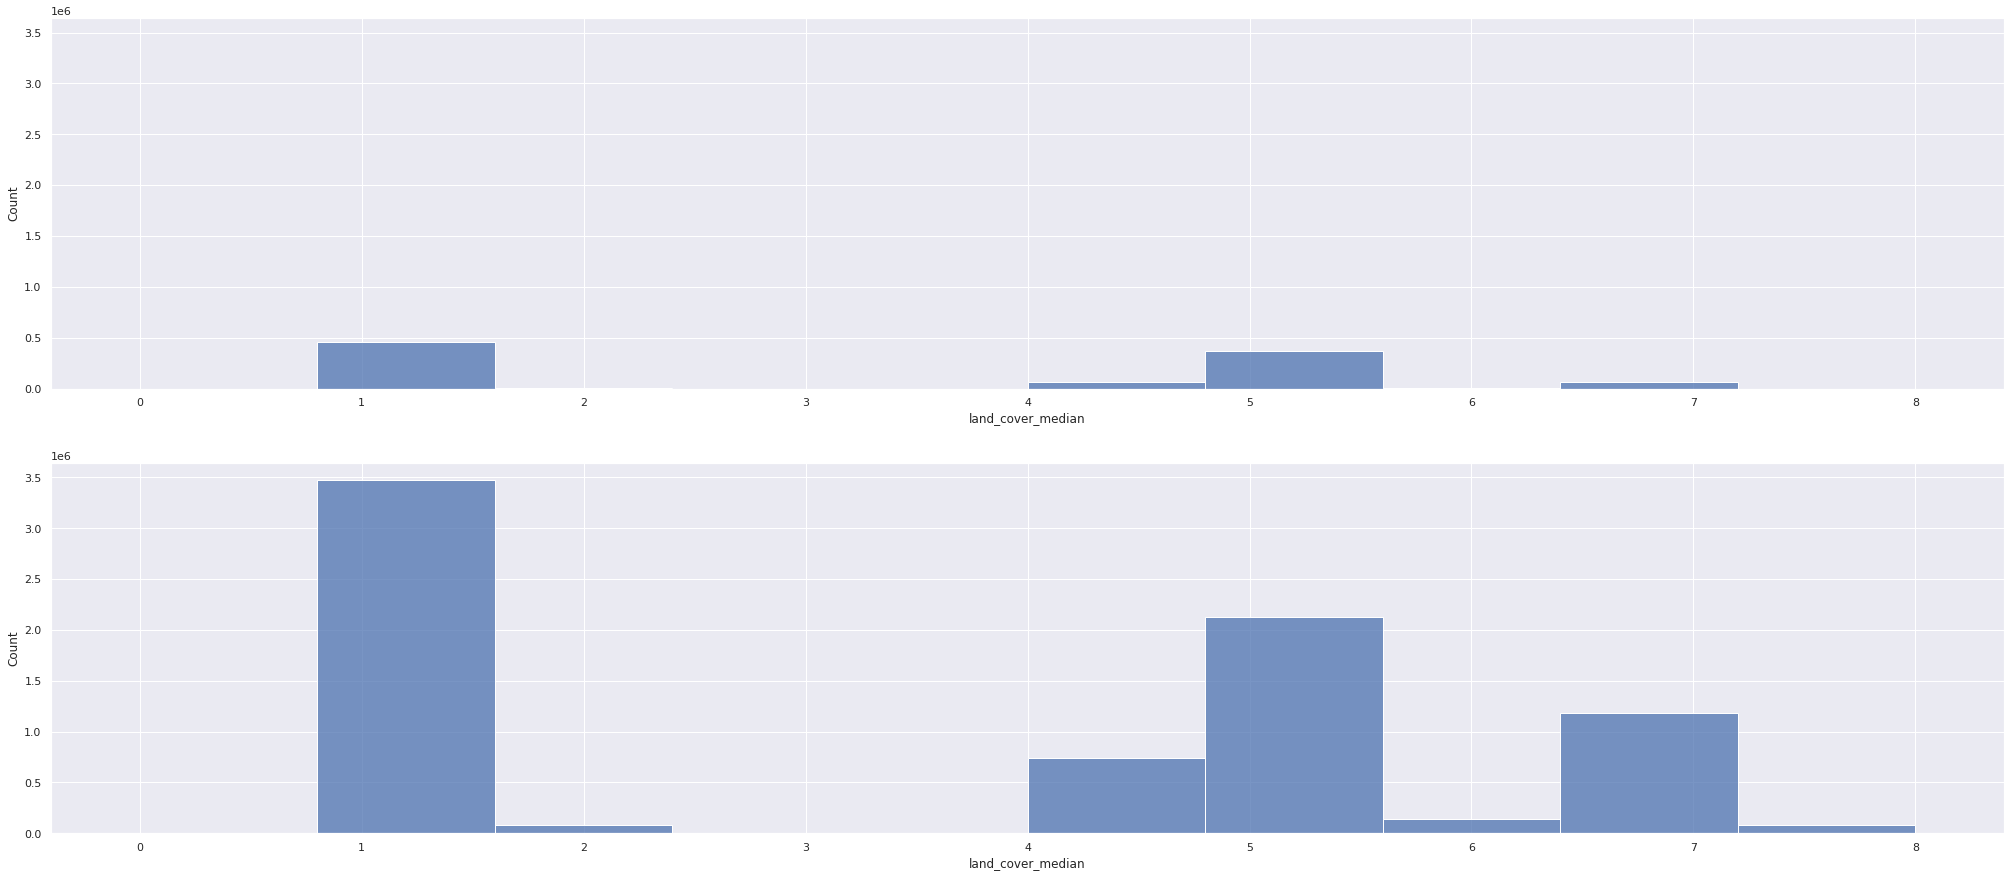

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(35, 15), sharey=True)
sns.histplot(gedi_burned, x='land_cover_median', ax=ax[0], bins=10)
sns.histplot(gedi_unburned, x='land_cover_median', ax=ax[1], bins=10)

<AxesSubplot: xlabel='land_cover_median', ylabel='Count'>

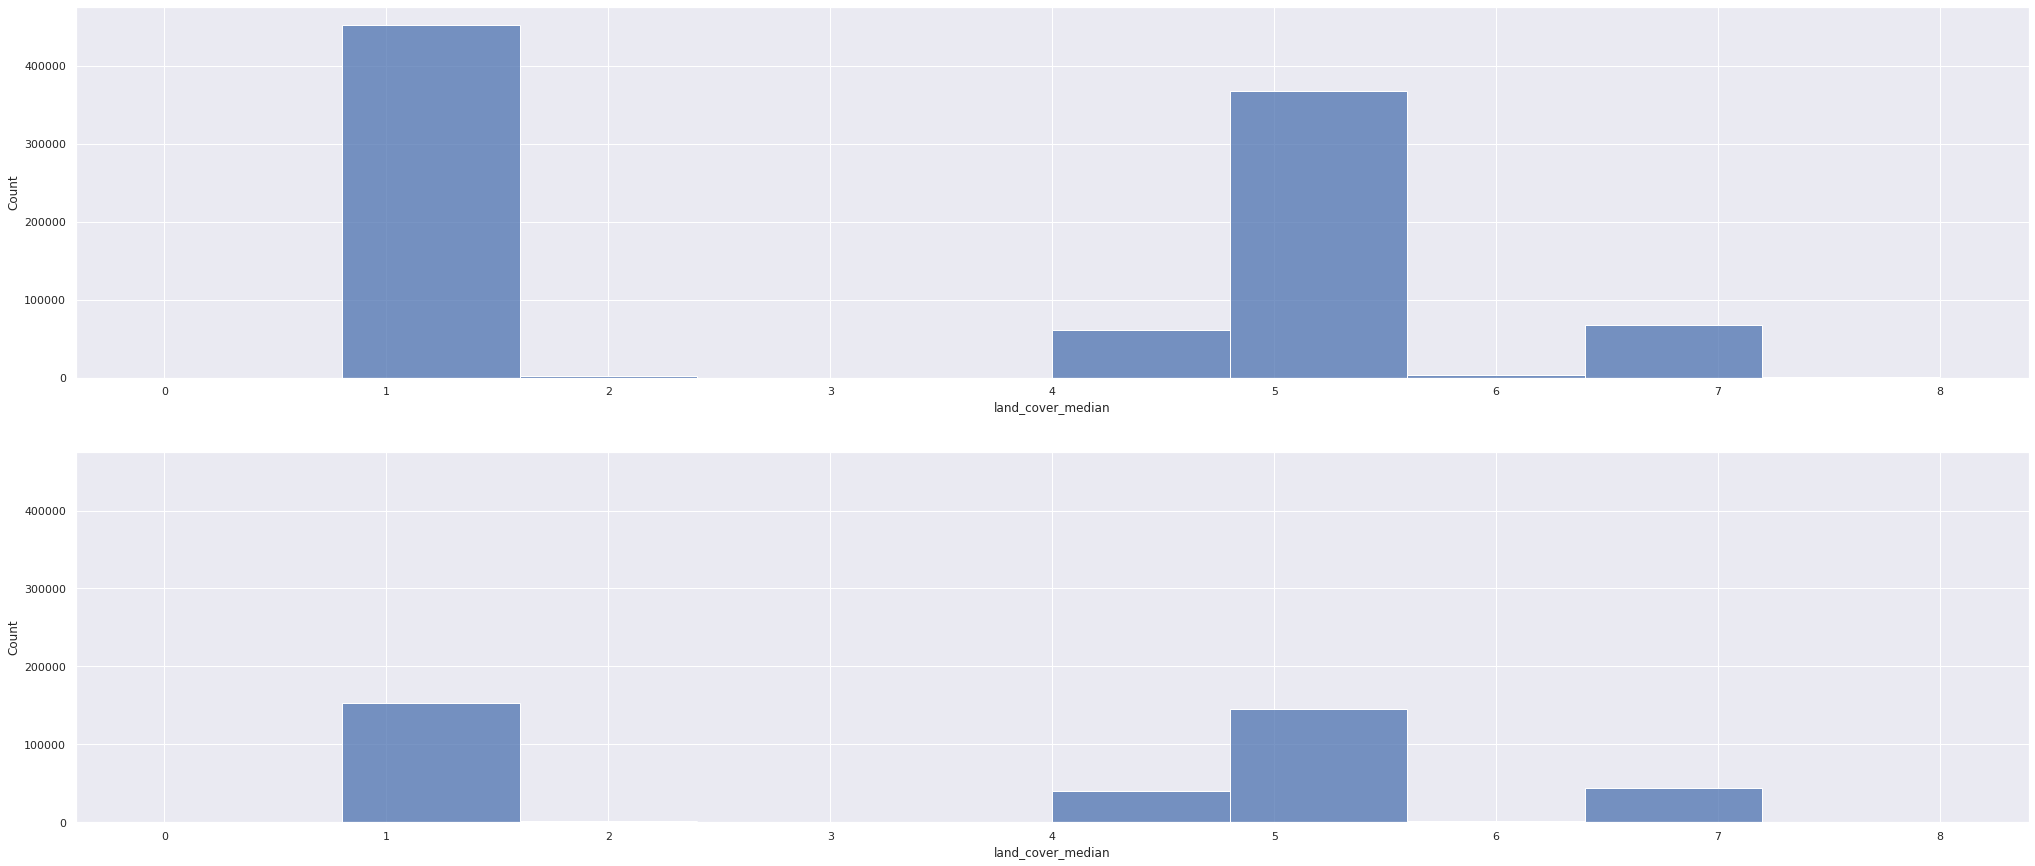

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(35, 15), sharey=True)
sns.histplot(gedi_burned, x='land_cover_median', ax=ax[0], bins=10)
sns.histplot(gedi_burned_perfect, x='land_cover_median', ax=ax[1], bins=10)

### Analyze only trees - land cover == 1

In [62]:
gedi_burned_trees = gedi_burned[(gedi_burned.land_cover_std == 0) & (gedi_burned.land_cover_median == 1)]
gedi_burned_perfect_trees = gedi_burned_perfect[(gedi_burned_perfect.land_cover_std == 0) & (gedi_burned_perfect.land_cover_median == 1)]
print(f'GEDI shots that burned trees: {gedi_burned_trees.shape[0]}')
print(f'GEDI perfect-match shots that burned trees: {gedi_burned_perfect_trees.shape[0]}')

GEDI shots that burned trees: 355106
GEDI perfect-match shots that burned trees: 126224


In [140]:
gedi_trees = pd.concat([gedi_burned_perfect_trees, gedi_unburned_trees])

In [141]:
# Get rid of the first two years as the number of samples is skewing the data.
gedi_trees = gedi_trees[(gedi_trees.time_since_burn != 1) & ((gedi_trees.time_since_burn != 2))]

In [142]:
# Bucket data
def time_categories(df):
    c = pd.cut(
        df[['time_since_burn']].stack(),
        [-np.inf, 0, 10, 20, 30, np.inf],
        labels=['unburned', 'burn_10', 'burn_20', "burn_30", "burn_40"]
    )
    return df.join(c.unstack().add_suffix('_cat'))

gedi_trees = time_categories(gedi_trees)

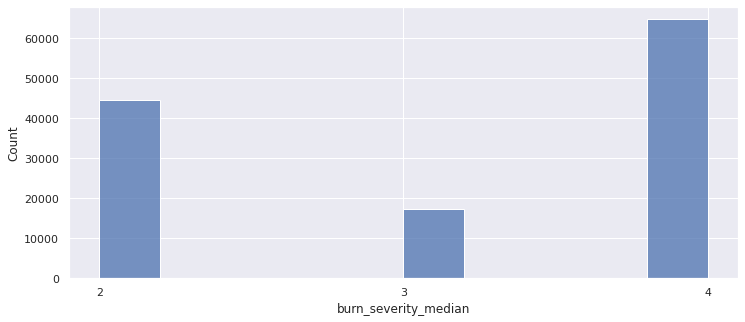

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
g = sns.histplot(gedi_burned_perfect_trees, x='burn_severity_median', bins=10)
g.set_xticks(range(2, 5))

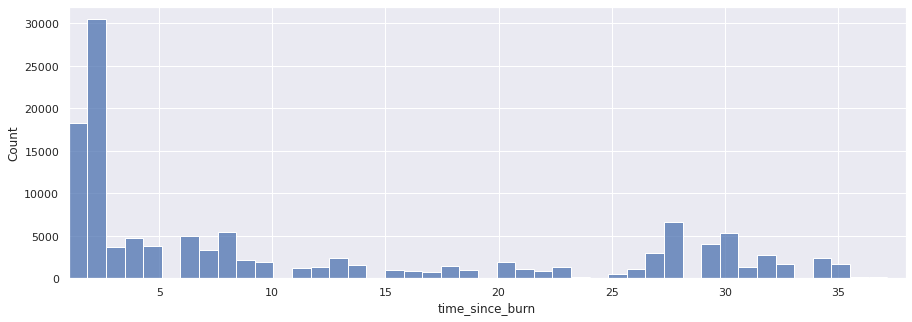

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_burned_perfect_trees, x='time_since_burn')
ax.margins(x=0)

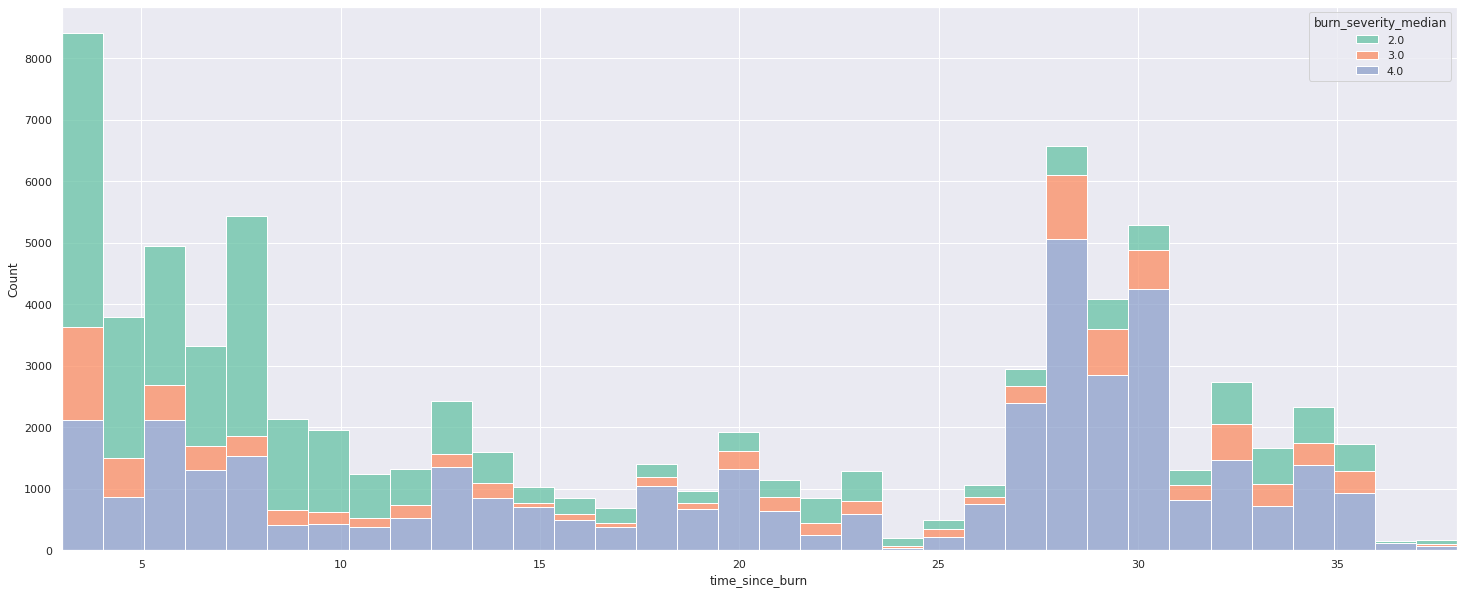

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', hue='burn_severity_median', palette='Set2', multiple="stack")
ax.margins(x=0)

### Boxplot comparisons

(0.0, 1000.0)

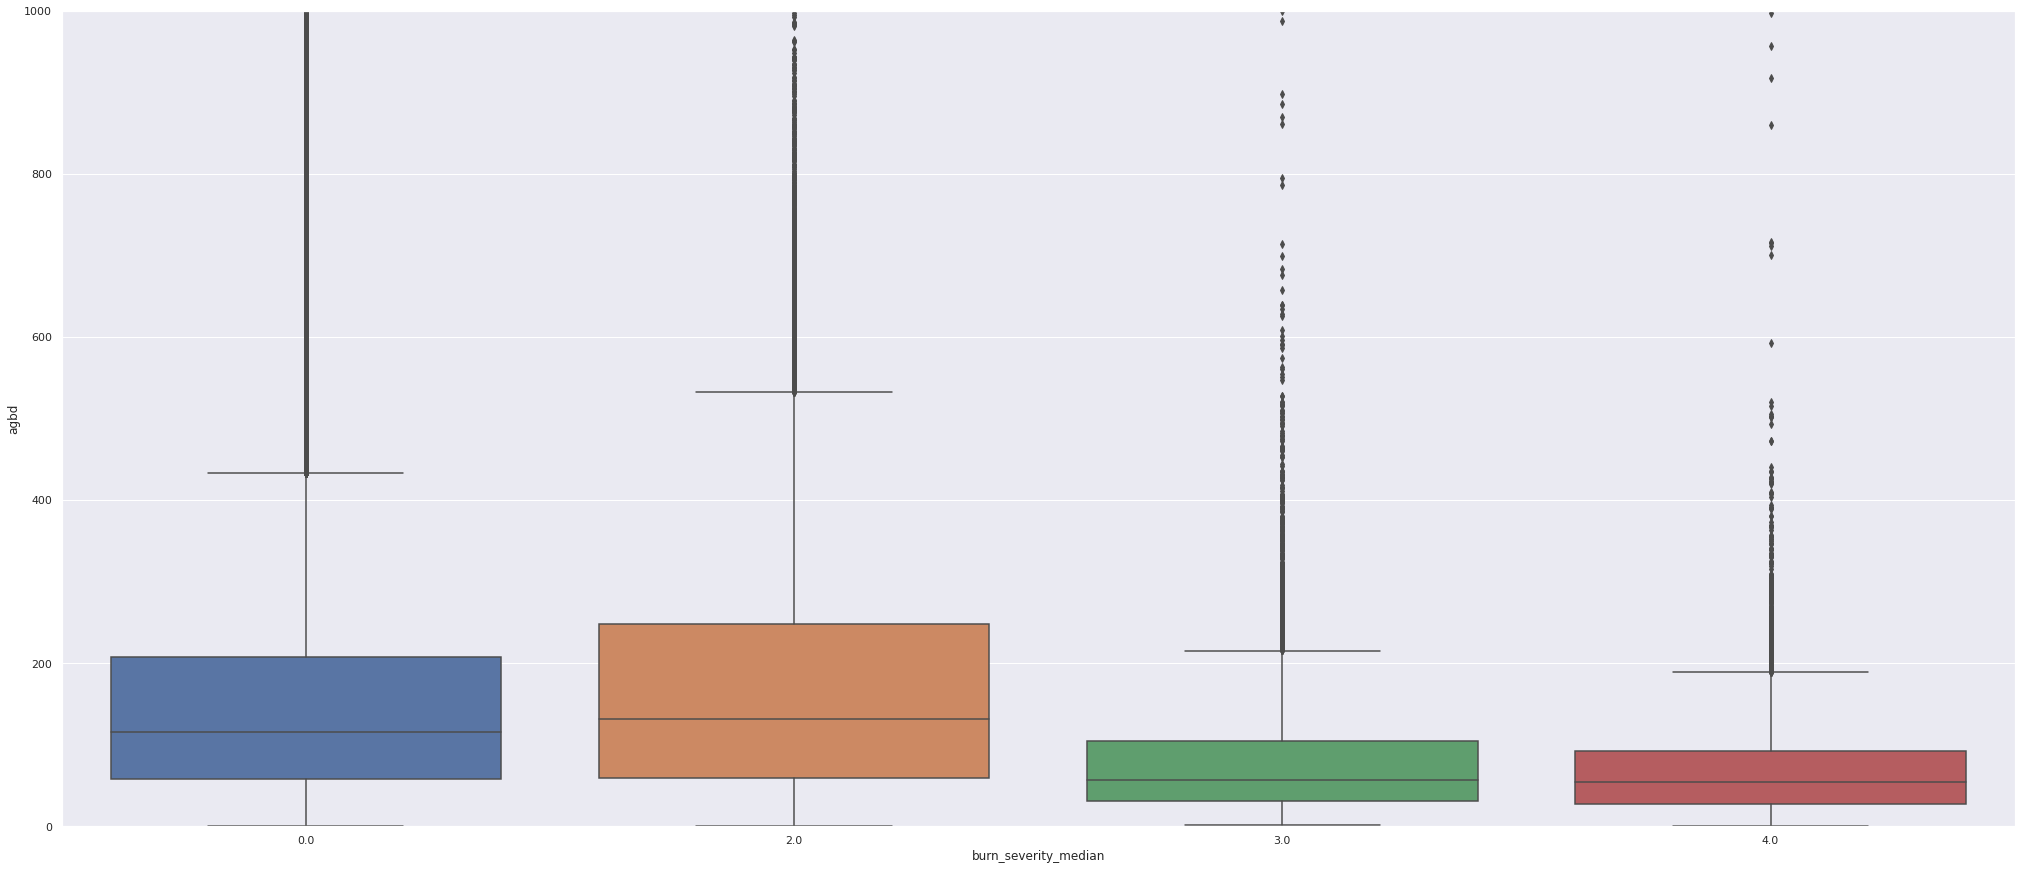

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

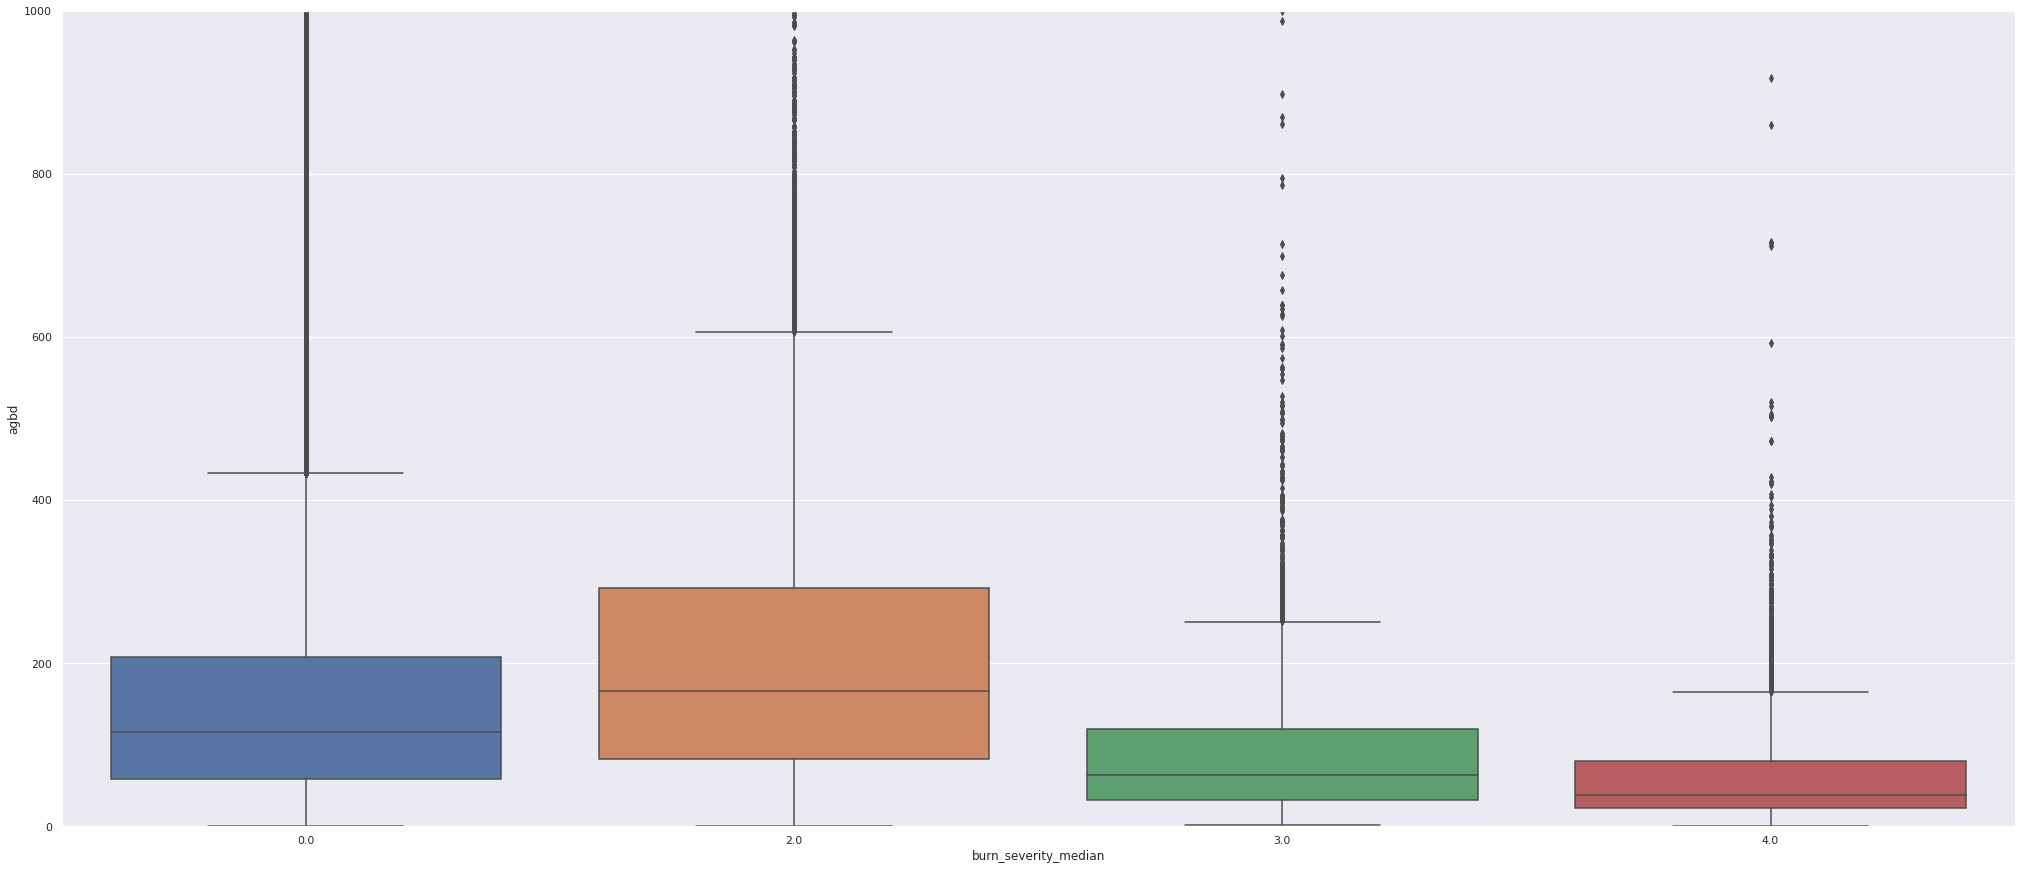

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_10'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

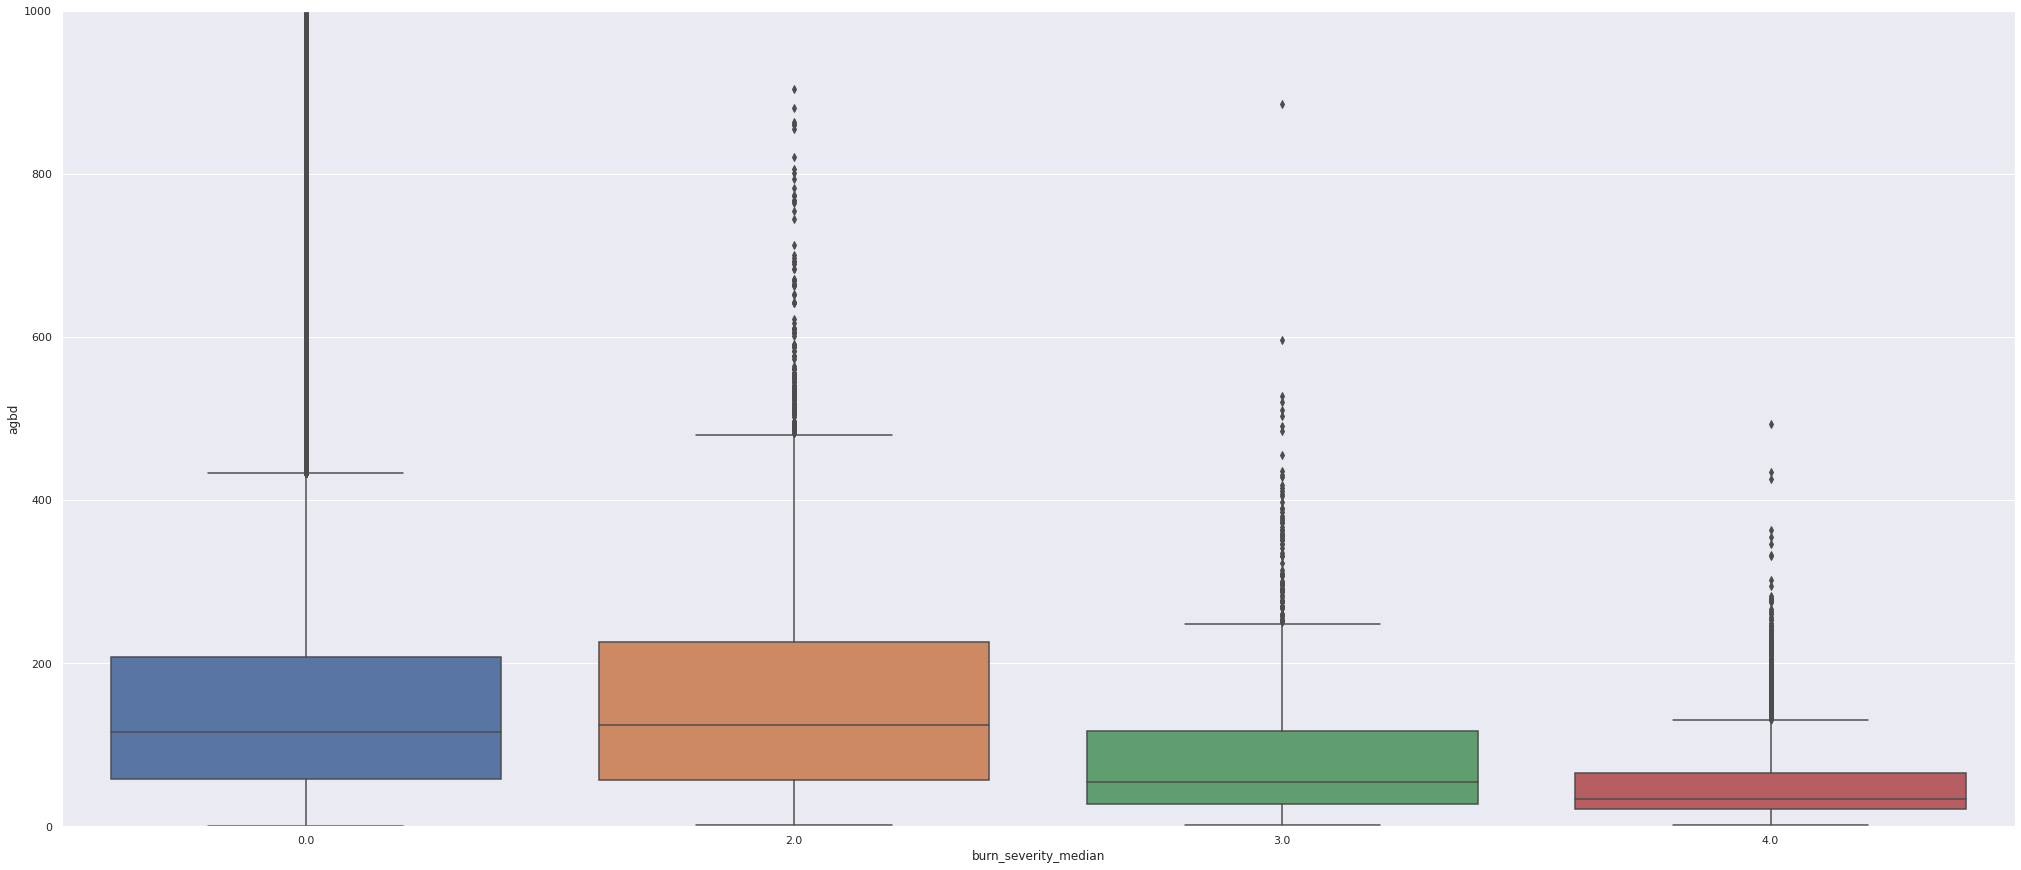

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_20'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

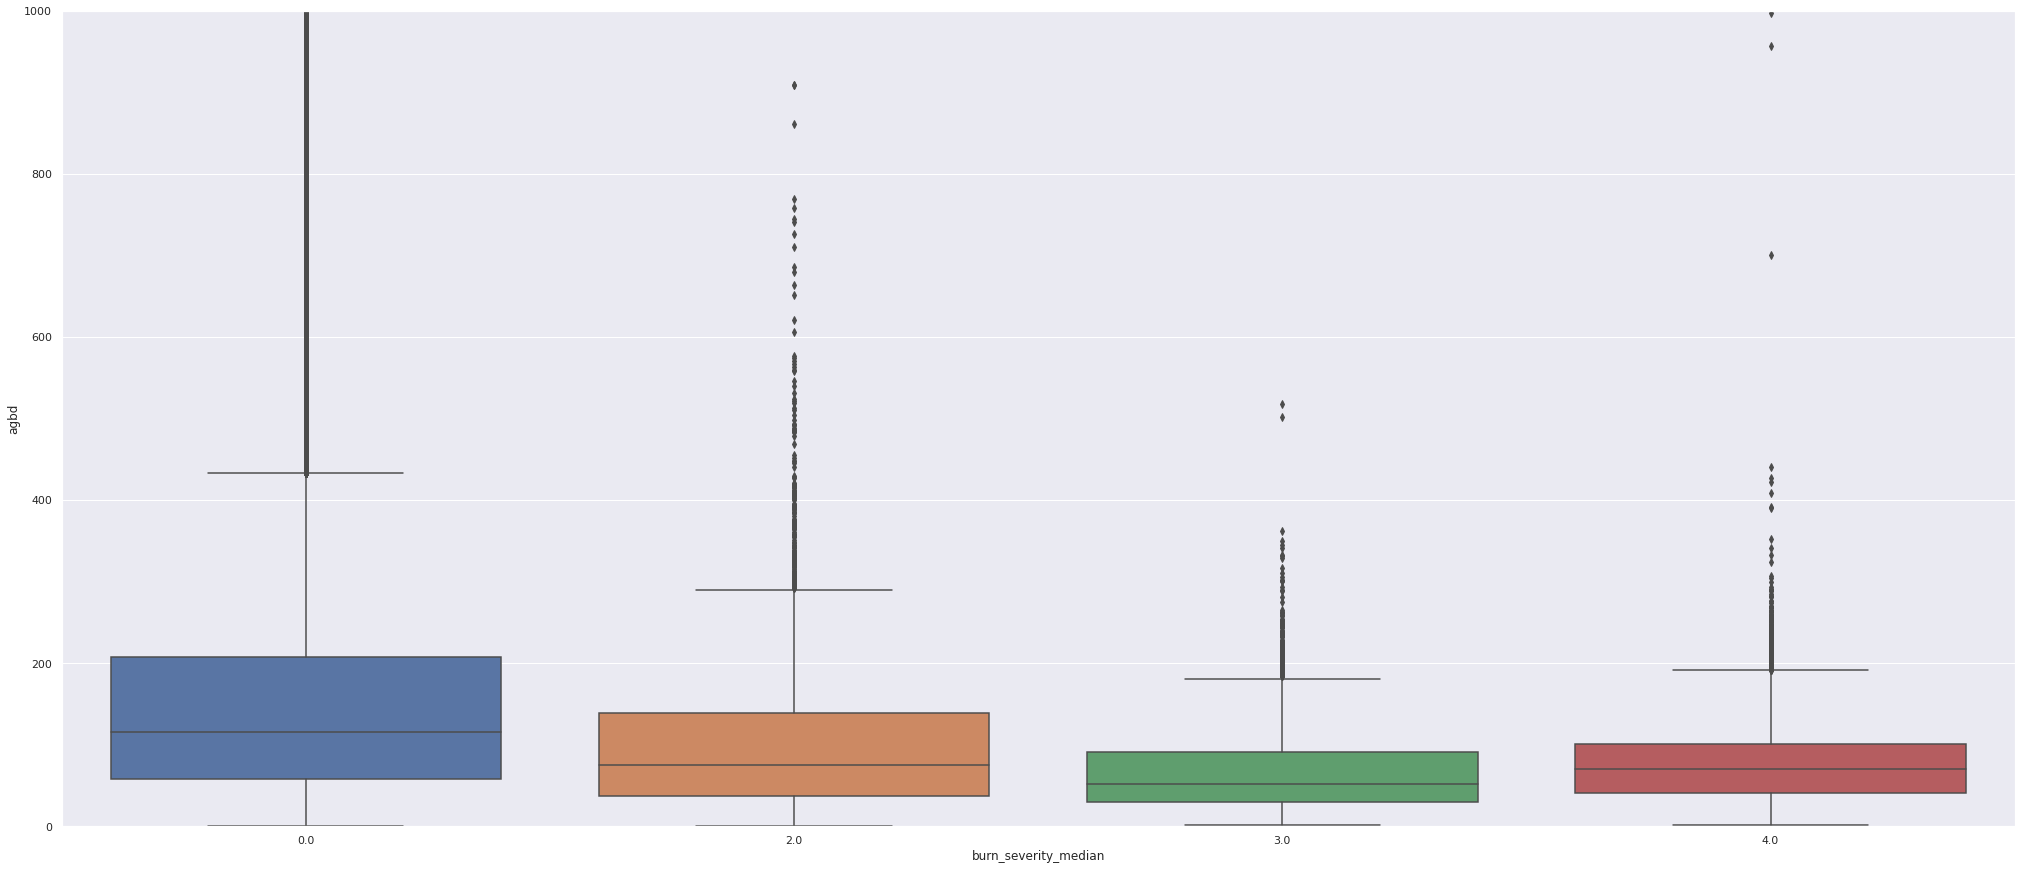

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_30'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

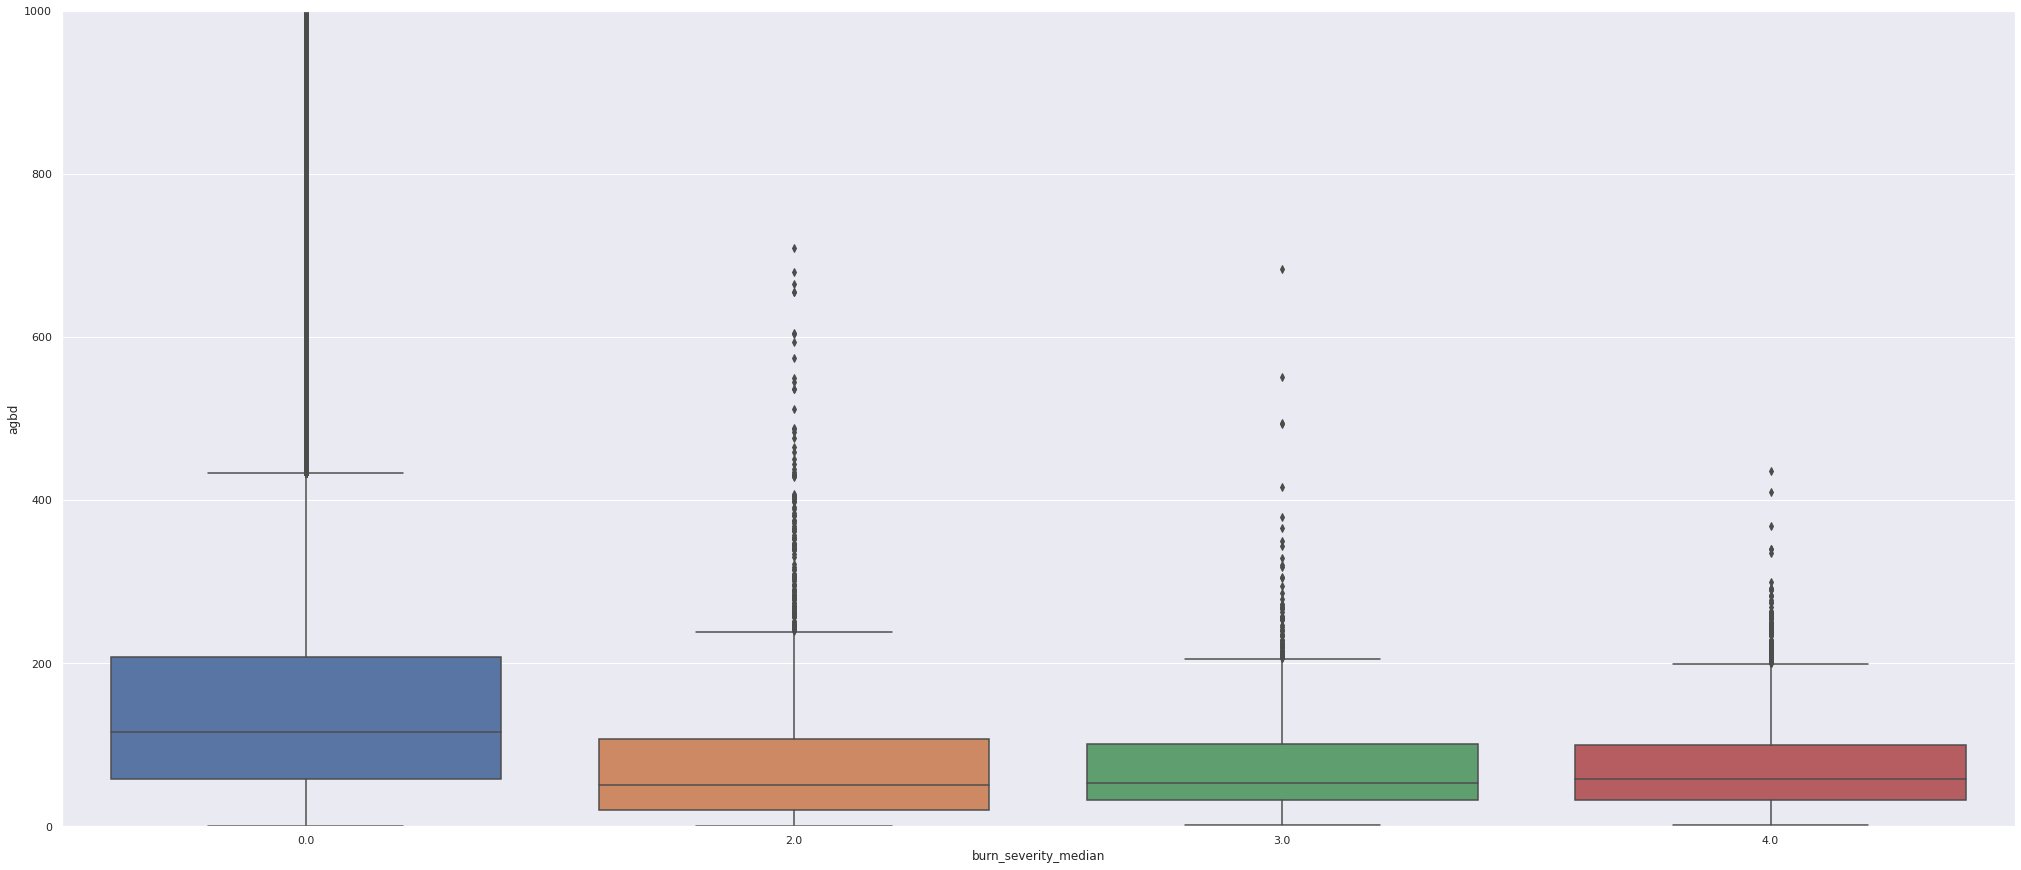

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_40'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

# AGBD timeplots

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

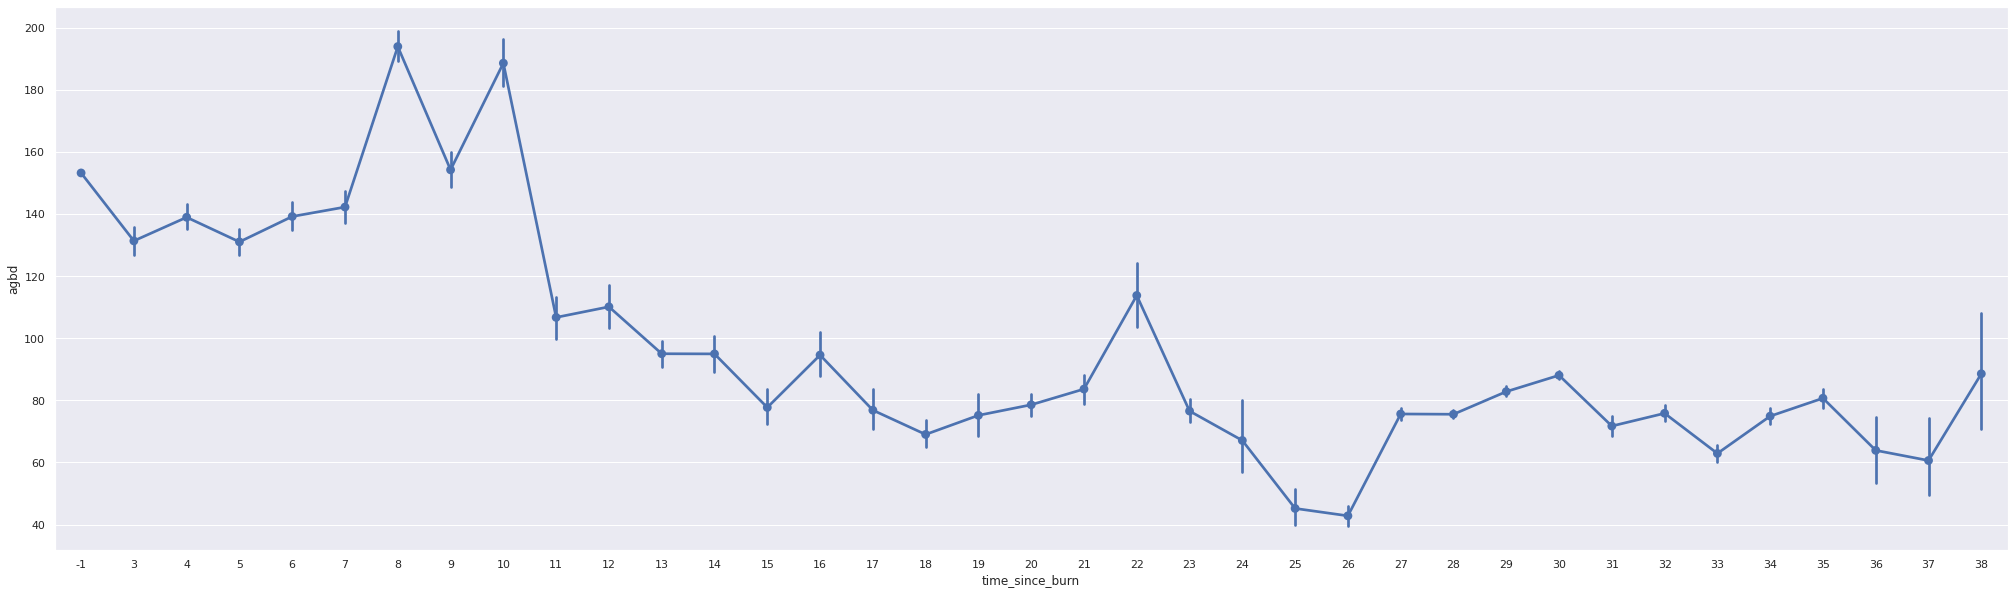

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

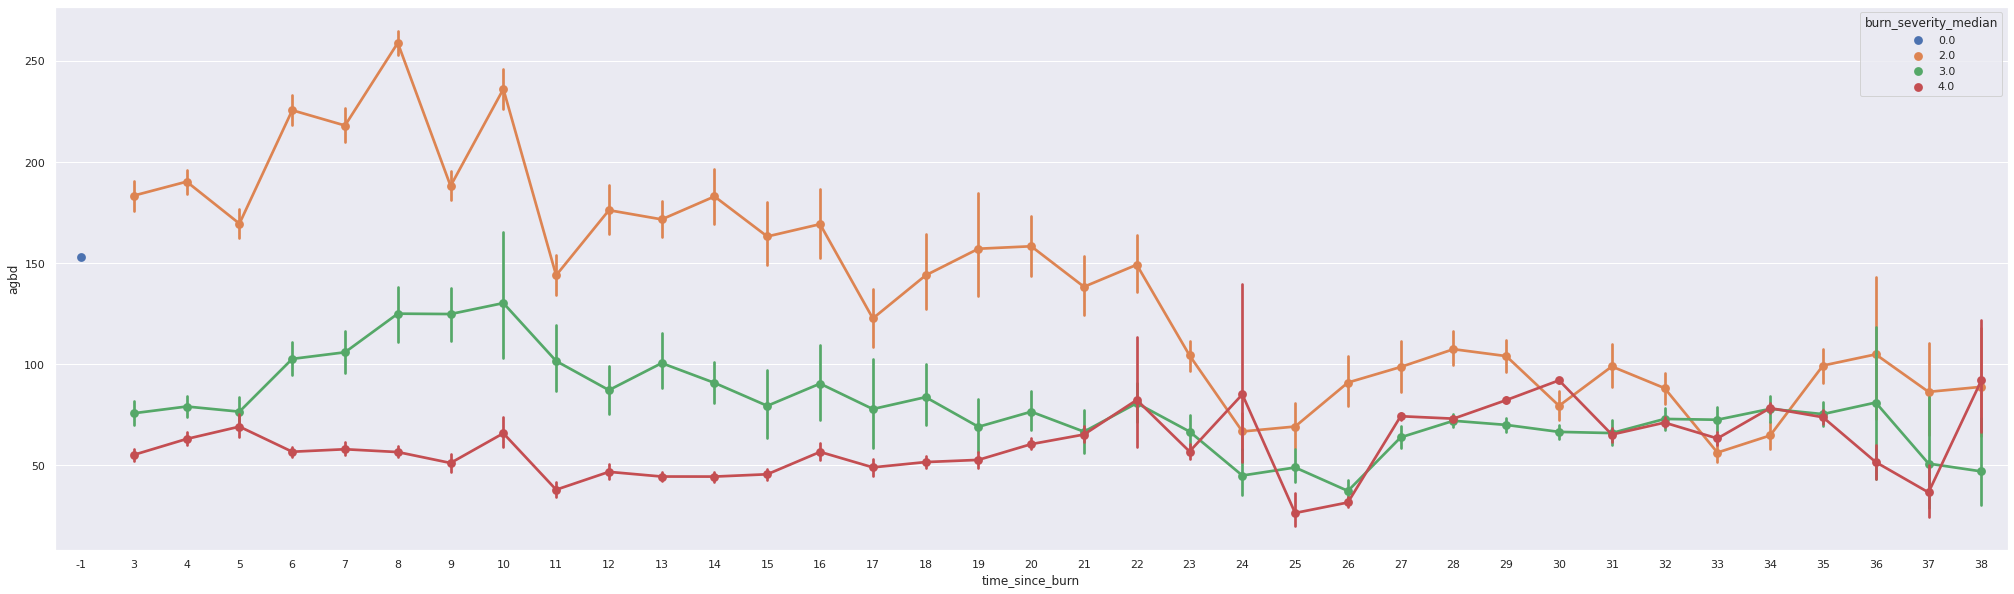

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd', hue='burn_severity_median')

Text(0, 0.5, 'GEDI AGBD')

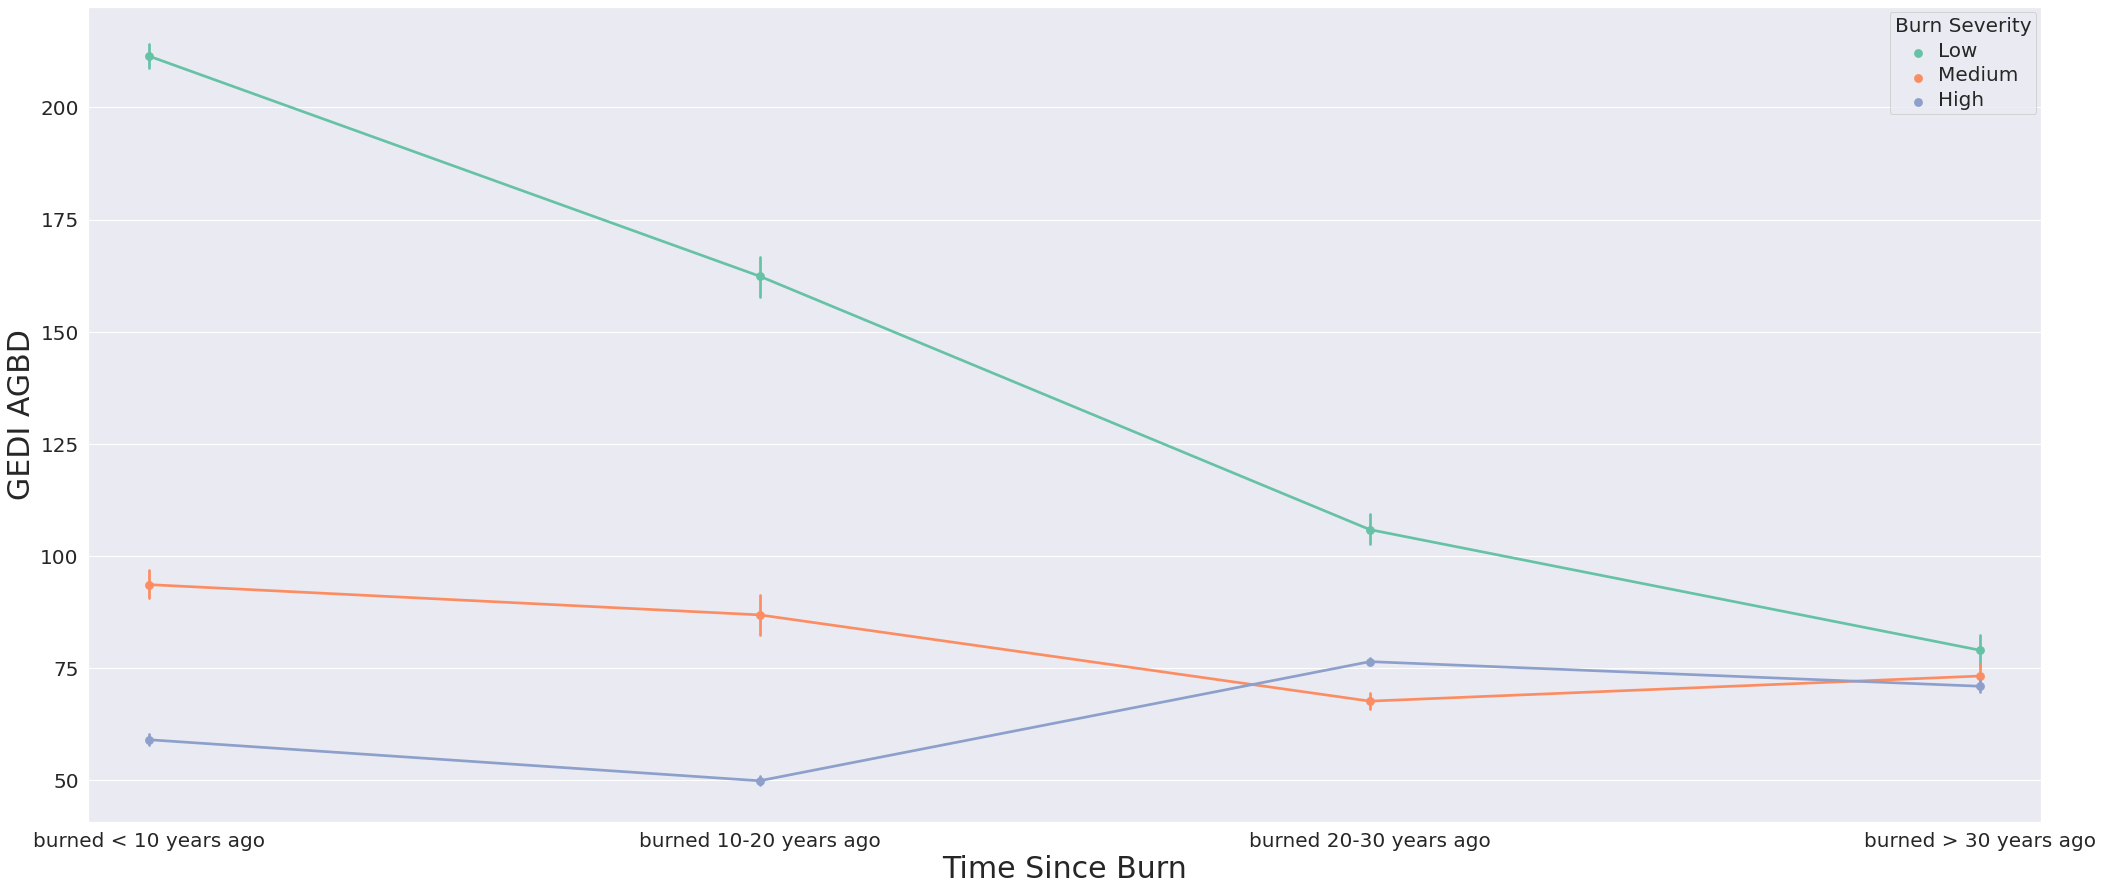

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

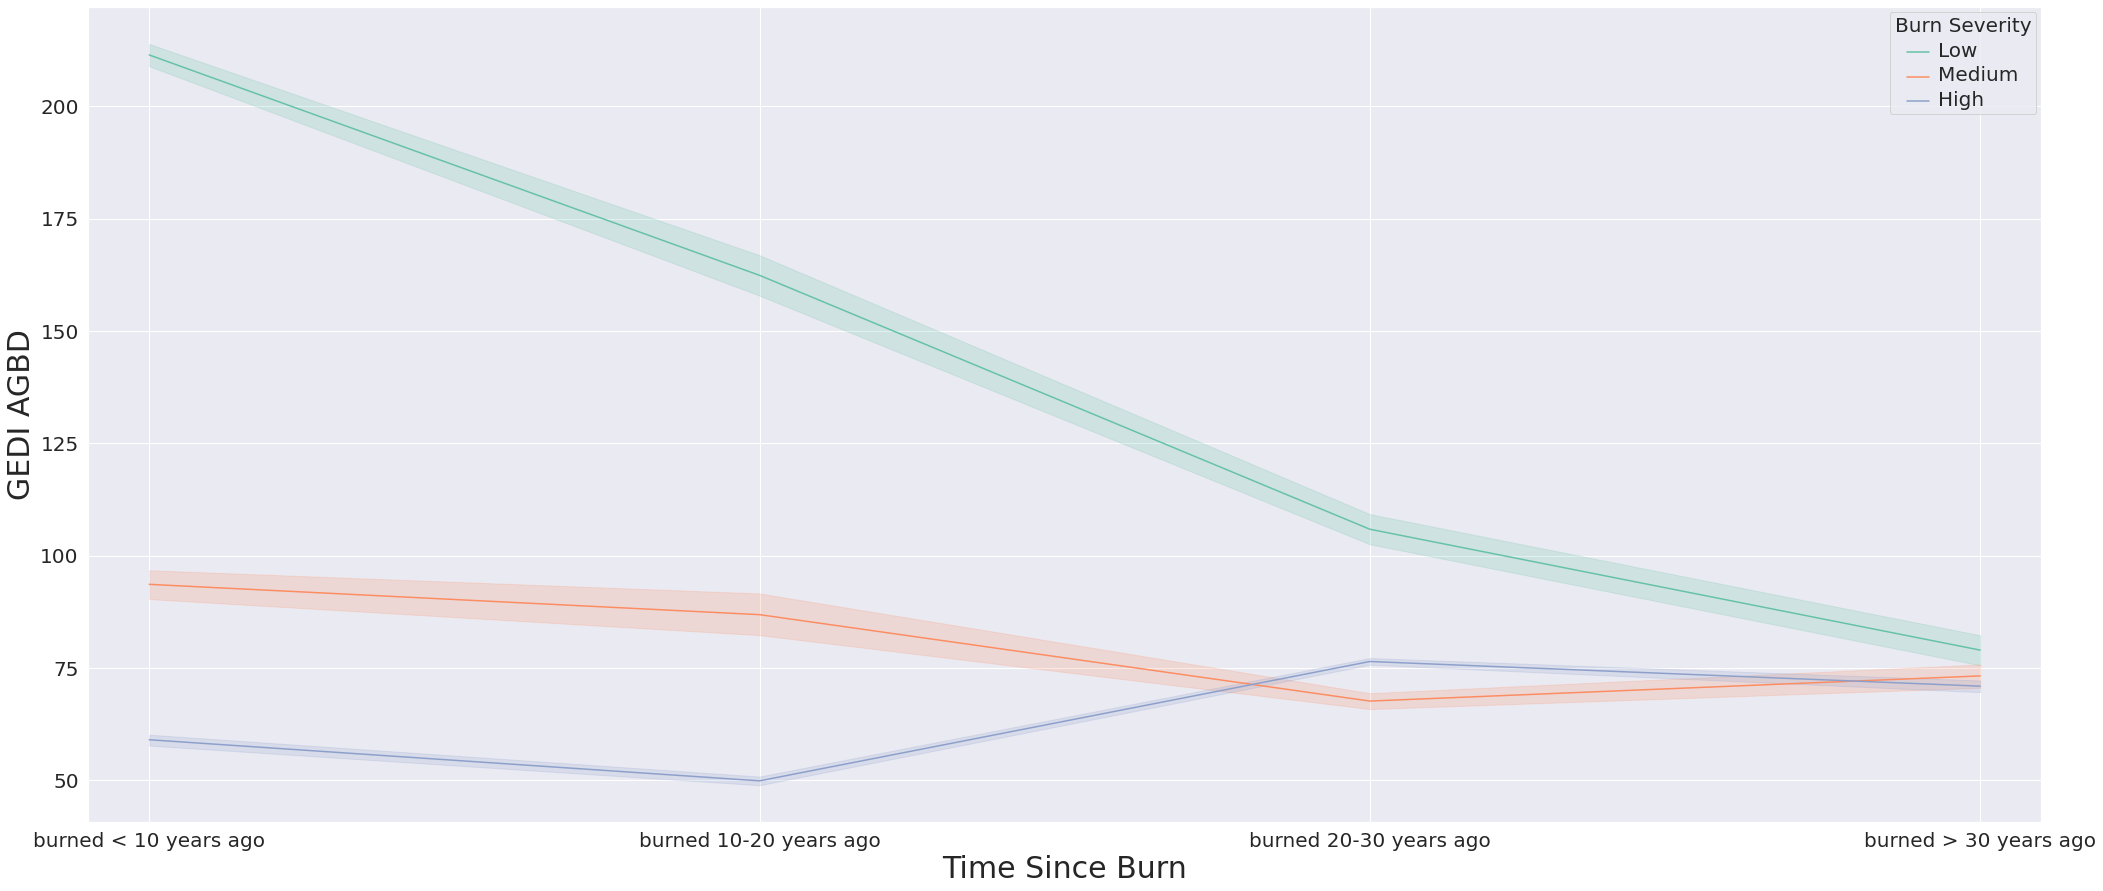

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

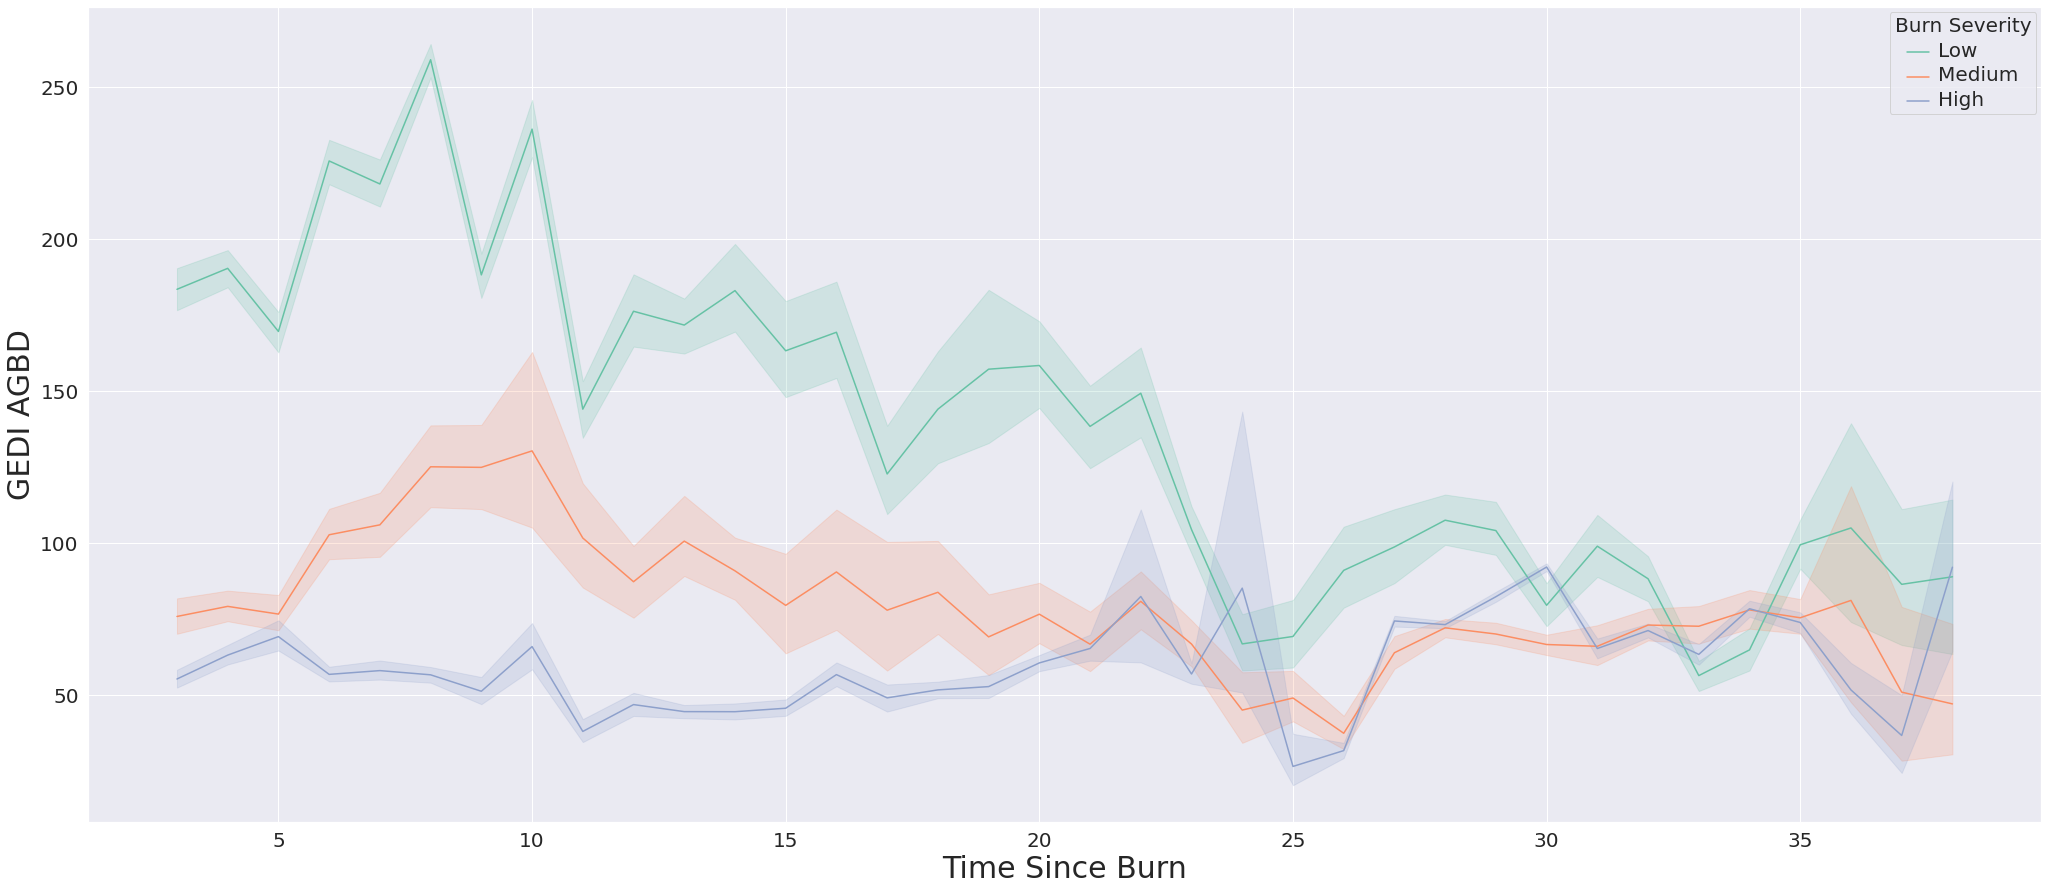

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

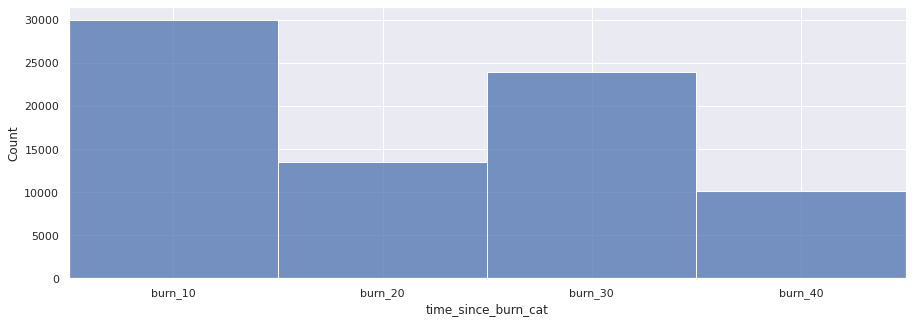

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat')
ax.margins(x=0)

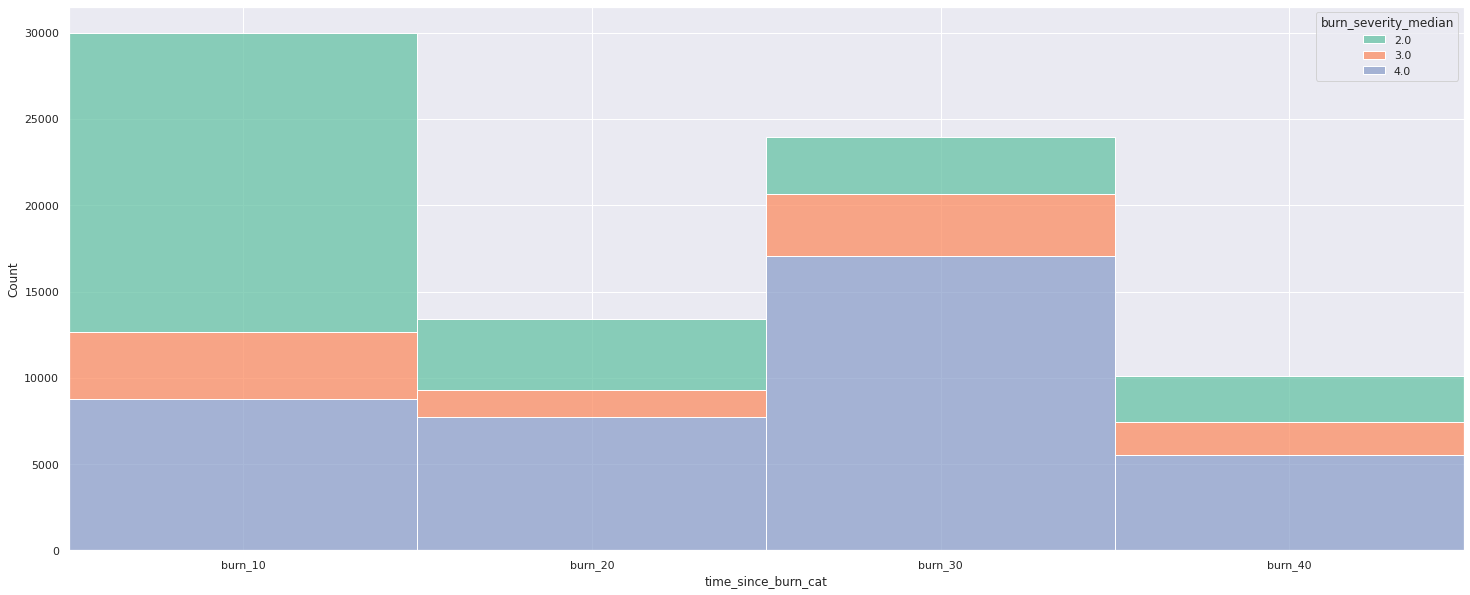

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', hue='burn_severity_median', palette='Set2', multiple="stack")
ax.margins(x=0)

Hypothesis to explain above: pixels that burned with low and medium severity > 30 years ago are more likely to reburn, than the ones that burned with high severity due to fuel reduction.

What percentage of each severity category reburns? Fire return interval must depend on the severity of the previous burn?

### Plot the data geographically

In [200]:
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

KeyboardInterrupt: 

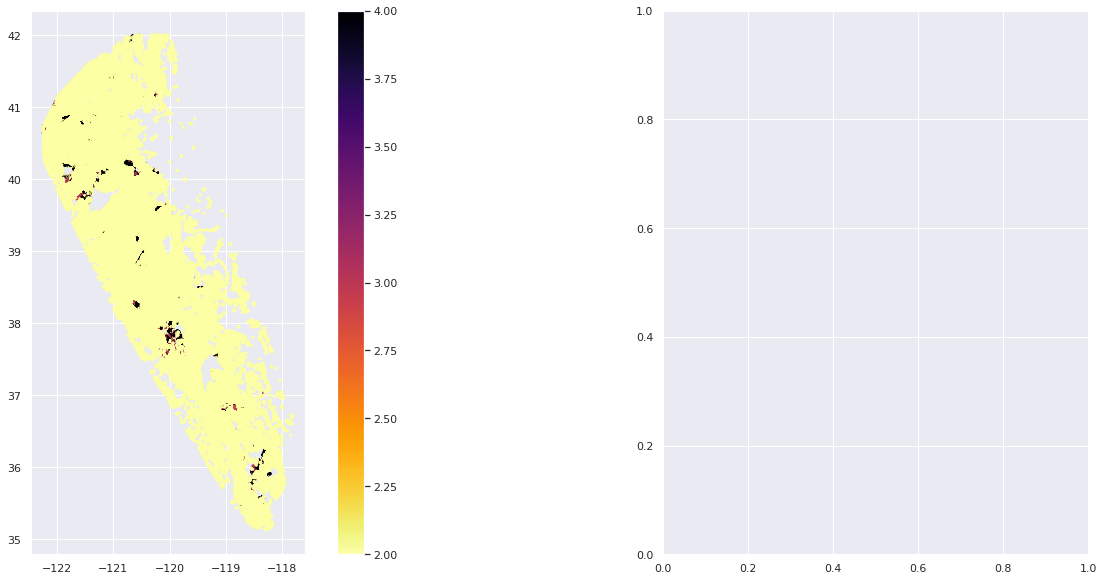

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
geo_plot(gedi_trees, ax[0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees, ax[1], 'agbd')

<AxesSubplot: >

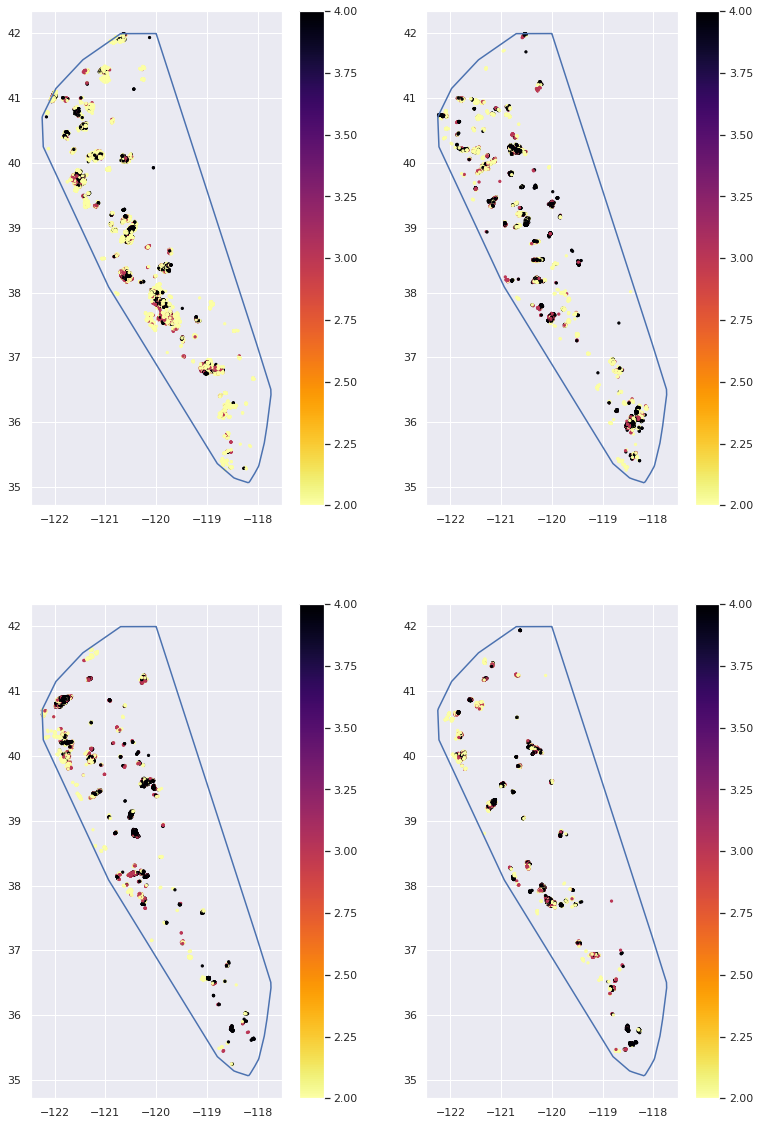

In [204]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'burn_severity_median', vmin=2, vmax=4)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

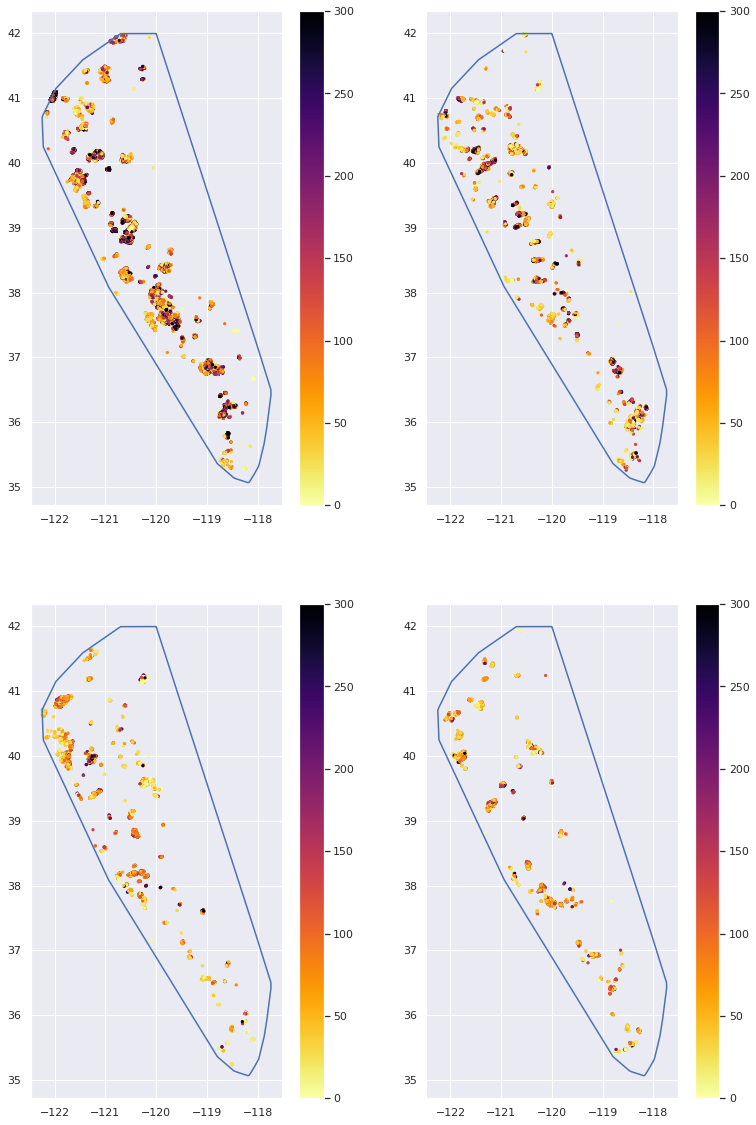

In [222]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'agbd', vmin=0, vmax=300)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

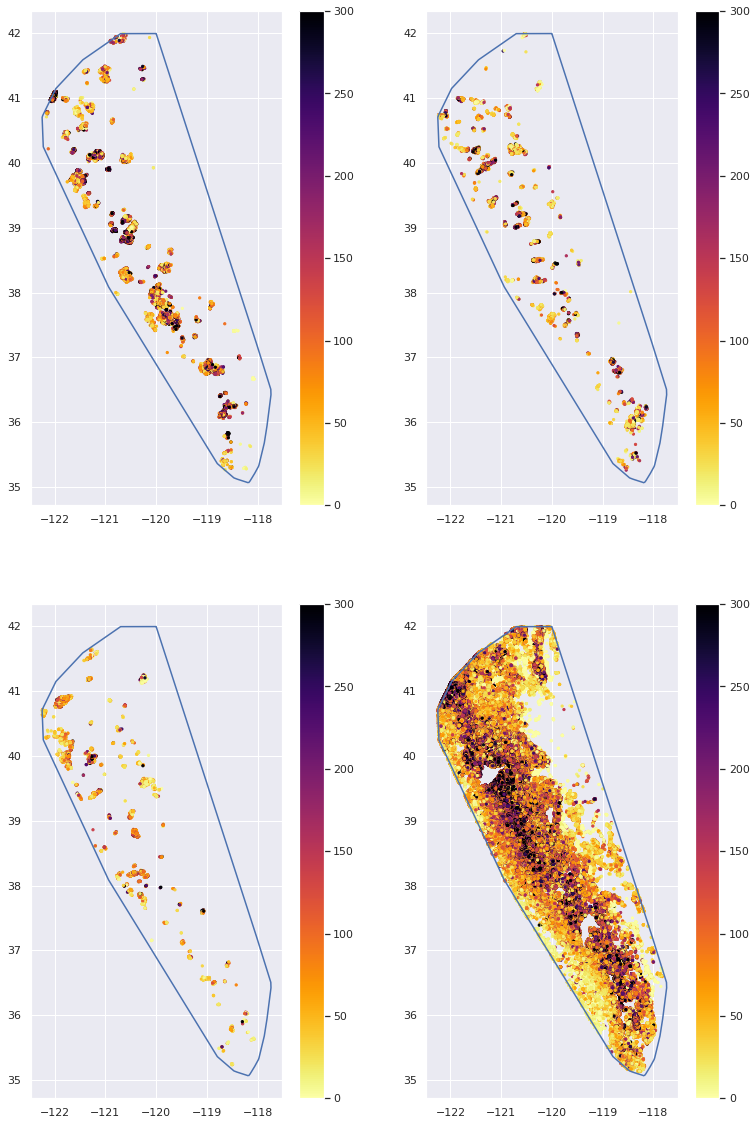

In [223]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees, ax[1][1], 'agbd', vmin=0, vmax=300)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

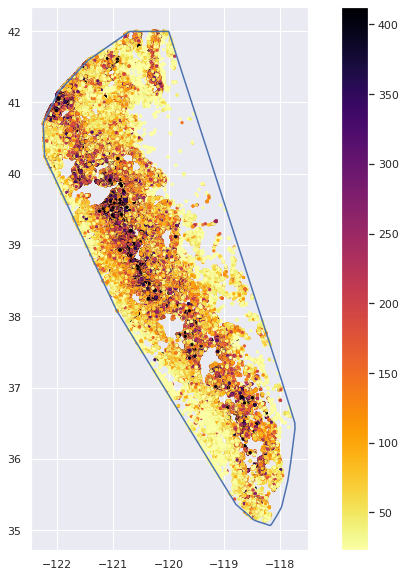

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'unburned'], ax, 'agbd')
sierras.boundary.plot(ax=ax)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

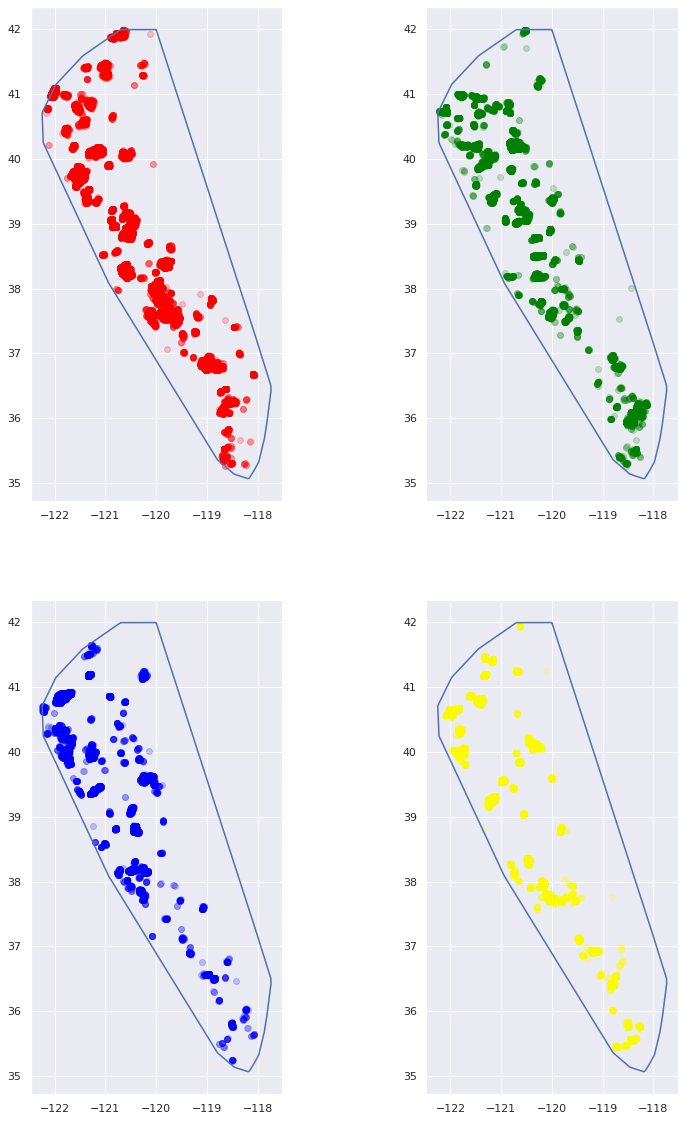

In [210]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax[0][0], legend=True, color='red', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax[0][1], legend=True, color='green', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax[1][0], legend=True, color='blue', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax[1][1], legend=True, color='yellow', alpha=0.2)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


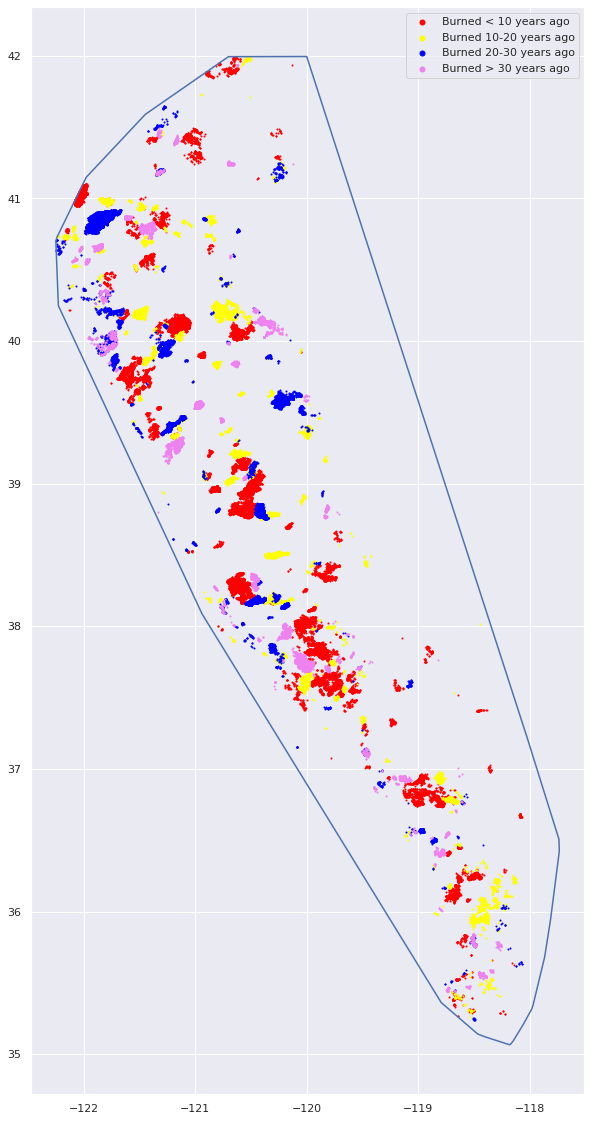

In [219]:
fig, ax = plt.subplots(1,1, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax, legend=True, color='red', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax, legend=True, color='yellow', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax, legend=True, color='blue', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax, legend=True, color='violet', markersize=1)

sierras.boundary.plot(ax=ax)
plt.legend(['Burned < 10 years ago', 'Burned 10-20 years ago', 'Burned 20-30 years ago', 'Burned > 30 years ago'], markerscale = 5)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_perfect_trees[gedi_burned_perfect_trees.burn_severity_sample == 2], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 1], x='time_since_burn', y='agbd', color='red')

### Look at unburned region

In [73]:
print(f'GEDI unburned shots: {gedi_unburned.shape[0]}')

GEDI unburned shots: 7829875


In [93]:
gedi_unburned.time_since_burn = 0

In [94]:
# Trees only
gedi_unburned_trees = gedi_unburned[(gedi_unburned.land_cover_std == 0) & (gedi_unburned.land_cover_median == 1)]
print(f'GEDI unburned tree shots: {gedi_unburned_trees.shape[0]}')

GEDI unburned tree shots: 2856458


In [78]:
print('AGBD stats for unburned')
print(gedi_unburned_trees.agbd.describe())

print('AGBD stats for burned')
print(gedi_burned_perfect_trees.agbd.describe())

AGBD stats for unburned
count    2.856458e+06
mean     1.531952e+02
std      1.317868e+02
min      4.797173e-01
25%      5.792078e+01
50%      1.157059e+02
75%      2.078579e+02
max      4.822505e+03
Name: agbd, dtype: float64
AGBD stats for burned
count    126224.000000
mean        110.389136
std         122.778903
min           0.834731
25%          32.127316
50%          69.451138
75%         136.369278
max        2114.207764
Name: agbd, dtype: float64


In [79]:
print('AGBD stats for burned, severity == 2')
print(gedi_burned_perfect_trees[gedi_burned_perfect_trees.burn_severity_median==2].agbd.describe())

print('AGBD stats for burned, severity == 3')
print(gedi_burned_perfect_trees[gedi_burned_perfect_trees.burn_severity_median==3].agbd.describe())

print('AGBD stats for burned, severity == 4')
print(gedi_burned_perfect_trees[gedi_burned_perfect_trees.burn_severity_median==4].agbd.describe())

AGBD stats for burned, severity == 2
count    44429.000000
mean       185.359152
std        159.512139
min          0.870713
25%         66.874855
50%        140.779327
75%        256.842957
max       1914.888306
Name: agbd, dtype: float64
AGBD stats for burned, severity == 3
count    17193.000000
mean        87.445992
std         93.397168
min          1.009095
25%         30.505957
50%         58.366970
75%        110.912811
max       2086.356445
Name: agbd, dtype: float64
AGBD stats for burned, severity == 4
count    64602.000000
mean        64.935723
std         59.686386
min          0.834731
25%         24.993123
50%         48.109180
75%         87.826307
max       2114.207764
Name: agbd, dtype: float64


(0.0, 1500.0)

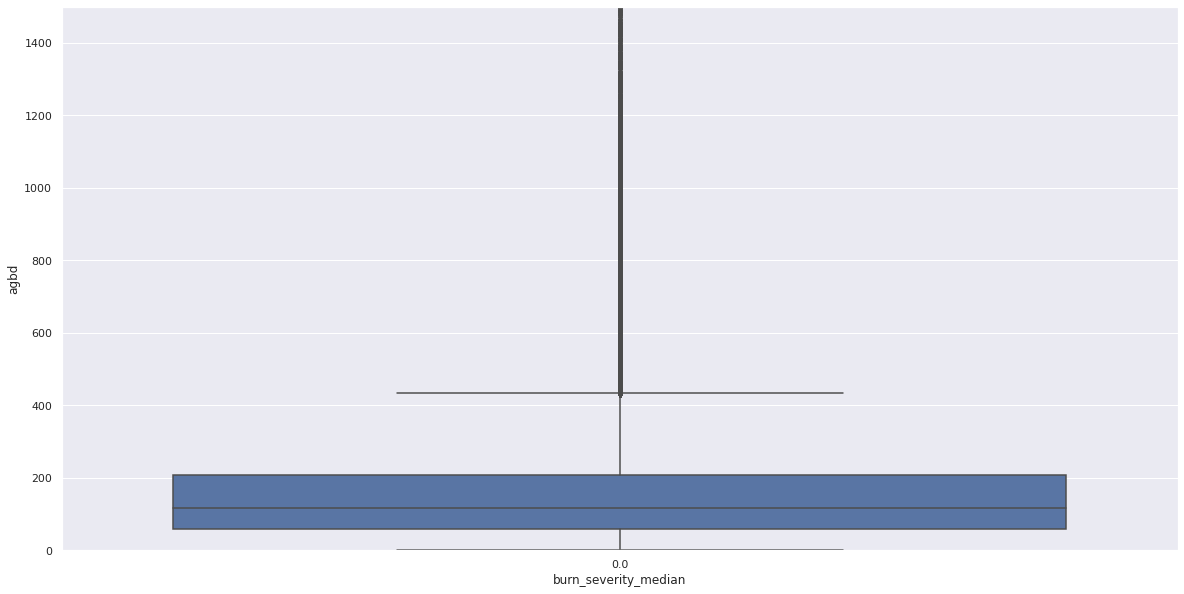

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(gedi_unburned_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1500))